###### For snscrape : for error, check appdata and install git

In [ ]:
pip install tweepy # for authentication
pip install textblob # for sentiment
!pip install snscrape # old version
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git # developer version for more attribute like reply count
pip install langdetect # filter english language tweets from csv
pip install ipynb # to use another .ipynb file
pip install patsy # for nb
pip install emoji # for emoji
pip install textstat # for flesch score

# Import libraries

In [1]:
from textblob import TextBlob
import tweepy
import sys
import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import re
import nltk
import string
from nltk.stem import PorterStemmer
from langdetect import detect
from ipynb.fs.full.stop_words import stopwords
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
import textstat
from gensim import corpora
import gensim
from wordcloud import WordCloud
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from textstat.textstat import textstatistics, legacy_round
import pickle

# Twitter authorization

In [ ]:
mykeys = open('twitter_keys.txt', 'r').read().splitlines()

# Twitter API credentials
api_keys = mykeys[0]
api_secret_key = mykeys[1]
access_token = mykeys[2]
access_token_secret = mykeys[3]

# create authentication 
auth = tweepy.OAuthHandler(consumer_key=api_keys, consumer_secret = api_secret_key)

# set access token and access toekn secret
auth.set_access_token(access_token, access_token_secret)

# creat eaPI object while passing in the auth information
api = tweepy.API(auth, wait_on_rate_limit = True)

# Check Twitter connection

In [ ]:
# extract 100 tweets from twitter user
posts = api.user_timeline(screen_name = 'JoeBiden', count = 125, lang = 'en', tweet_mode = 'extended')
print('show 5 recent tweets \n')
for tweet in posts[0:50]:
    print(tweet.full_text + '\n')

# Extract Tweets, no. of likes, retweets and comments

In [ ]:
maxTweets = 1000

# create csv file
csvBiden = open('JoeBiden.csv', 'a', newline='', encoding='utf8')
csvTrump = open('Trump.csv', 'a', newline='', encoding='utf8')

# write in created csv files
csvWriterBiden = csv.writer(csvBiden)
csvWriterBiden.writerow(['ID', 'Date', 'Tweet', 'Reply_count', 'Retweet_count', 'Like_count'])

csvWriterTrump = csv.writer(csvTrump)
csvWriterTrump.writerow(['ID', 'Date', 'Tweet', 'Reply_count', 'Retweet_count', 'Like_count'])

# tweets from september to november 2020
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@JoeBiden + since:2020-9-03 until:2020-11-03').get_items()):
    if i > maxTweets:
        break
    csvWriterBiden.writerow([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount])
    
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@WhiteHouse45 + since:2020-9-03 until:2020-11-03').get_items()):
    if i > maxTweets:
        break
    csvWriterTrump.writerow([tweet.id, tweet.date, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount])
    
# close csv files
csvBiden.close()
csvTrump.close()

# Data Cleaning

In [2]:
# Open file
dfbiden = pd.read_csv('JoeBiden.csv')

# merge both csv files
all_tweets = dfbiden

# check top 5 rows and column names and shape
# all_tweets.head()
# all_tweets.columns
all_tweets.shape

# check duplicate tweets
# all_tweets.tweet.unique()

# check 0 values in counts
# all_tweets.isna().sum()

(879, 6)

In [3]:
# remove non english tweets
def detect_lang(text):
    try:
        return detect(text) == 'en'
    except:
        return False

all_tweets = all_tweets[all_tweets['Tweet'].apply(detect_lang)]

In [4]:
# remove links
all_tweets['Tweet'] = all_tweets['Tweet'].replace(to_replace=r'https?:\/\/.*[\r\n\s]*',value='',regex=True)

<ipython-input-4-f59ea6545fa9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].replace(to_replace=r'https?:\/\/.*[\r\n\s]*',value='',regex=True)


In [5]:
# check number of rows after removing non English tweets
all_tweets.shape

(846, 6)

In [6]:
# remove usernames
all_tweets['Tweet'] = all_tweets['Tweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)", "", x).split()))

<ipython-input-6-b4c98fbfd5b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)", "", x).split()))


In [7]:
def strip_emoji(text):
    new_text = re.sub(emoji.get_emoji_regexp(), r"", text)
    return new_text

all_tweets['Tweet'] = all_tweets['Tweet'].apply(lambda x: strip_emoji(x))

<ipython-input-7-b90f761c39db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].apply(lambda x: strip_emoji(x))


In [8]:
all_tweets.describe()

,ID,Reply_count,Retweet_count,Like_count
count,8.460000e+02,846.000000,846.000000,8.460000e+02
mean,1.314772e+18,5607.776596,15034.667849,9.768625e+04
std,6.394409e+15,6613.414468,22888.841267,1.522697e+05
min,1.301316e+18,81.000000,619.000000,2.497000e+03
25%,1.309970e+18,1856.750000,4037.000000,2.067800e+04
50%,1.315777e+18,3302.500000,8114.500000,4.255750e+04
75%,1.320392e+18,6327.000000,17658.000000,1.136115e+05
max,1.323410e+18,52117.000000,303586.000000,1.838618e+06


# Measure sophistication words

###### Designed to indicate how difficult a reading passage is to understand. Higher scores indicate material that is easier to read; lower numbers mark harder-to-read passages.

FRE = 206.835 − 1.015*(total words/ 
total sentences) − 84.6 * (total
syllables/ total words)
Used this article https://www.kaggle.com/fshenbayh/readability

In [9]:
all_tweets['FRE'] = all_tweets['Tweet'].apply(lambda x: textstat.flesch_reading_ease(x))
all_tweets['FRE']

<ipython-input-9-f0cc9d24a15b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['FRE'] = all_tweets['Tweet'].apply(lambda x: textstat.flesch_reading_ease(x))


0      61.83
1      94.15
2      58.28
3      60.99
4      80.11
       ...  
874    67.25
875    66.44
876    71.14
877    86.40
878    90.77
Name: FRE, Length: 846, dtype: float64

Text(0.5, 1.0, 'Histogram of Flesch Score of tweets')

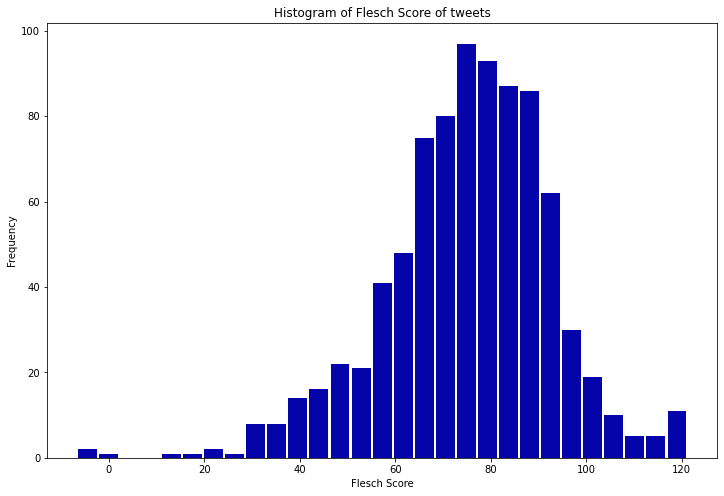

In [10]:
# histogram for Flesch score
flesch_score = all_tweets.hist(column='FRE', bins='auto', color='#0504aa',
                            grid=False, figsize=(12,8), zorder=2, rwidth=0.9)
plt.xlabel('Flesch Score')
plt.ylabel('Frequency')
plt.title('Histogram of Flesch Score of tweets') 

In [11]:
# remove punctuations and replace special words with '_'
all_tweets['Tweet'] = all_tweets['Tweet'].str.replace(r"[\’\']", '_')
all_tweets['Tweet'] = all_tweets['Tweet'].str.replace(r"[\‘\“\”\"\``\''\`\”\...\“—–]", '')

all_tweets

<ipython-input-11-33c63140bcf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].str.replace(r"[\’\']", '_')
<ipython-input-11-33c63140bcf0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].str.replace(r"[\‘\“\”\"\``\''\`\”\...\“—–]", '')


,ID,Date,Tweet,Reply_count,Retweet_count,Like_count,FRE
0,1323409554567094272,2020-11-02 23:40:00+00:00,Donald Trump is the most corrupt president in ...,18961,31847,207292,61.83
1,1323404521523982338,2020-11-02 23:20:00+00:00,The power to change this country is in your ha...,1630,3452,19379,94.15
2,1323400746939883522,2020-11-02 23:05:00+00:00,Here_s the truth: Donald Trump inherited a gro...,11611,34213,260334,58.28
3,1323391493885718528,2020-11-02 22:28:14+00:00,I_m speaking with members of the African Ameri...,1538,1896,13395,60.99
4,1323383130435260419,2020-11-02 21:55:00+00:00,"When America votes, America will be heard And ...",5853,16643,141492,80.11
...,...,...,...,...,...,...,...
874,1301594146390466562,2020-09-03 18:53:21+00:00,It_s time we come together as a nation to heal...,2166,4127,14866,67.25
875,1301560082933530625,2020-09-03 16:38:00+00:00,"Right now, classrooms should be humming with e...",7468,15454,77576,66.44
876,1301535924111761408,2020-09-03 15:02:00+00:00,I_ve always believed we_re at our best when we...,4873,12480,74454,71.14
877,1301322769045557250,2020-09-03 00:55:00+00:00,"Time and time again, President Trump has refus...",3723,9402,35384,86.40


# Sentiment analysis

In [12]:
# create new columns for polarity, compound and sentiment
analyzer = SentimentIntensityAnalyzer()

for index, text in all_tweets['Tweet'].iteritems():
    senti = analyzer.polarity_scores(text)
    neg = senti['neg']
    pos = senti['pos']
    neu = senti['neu']
    comp = senti['compound']
    
    if neg > pos:
        all_tweets.loc[index, 'Sentiment'] = 'Negative'
    elif neg < pos:
        all_tweets.loc[index, 'Sentiment'] = 'Positive'
    else:
        all_tweets.loc[index, 'Sentiment'] = 'Neutral'
        
    all_tweets.loc[index, 'Neg_pol'] = neg
    all_tweets.loc[index, 'Pos_pol'] = pos
    all_tweets.loc[index, 'Neu_pol'] = neu
    all_tweets.loc[index, 'Compound'] = comp
    
all_tweets

C:\Users\priya\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\priya\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ID,Date,Tweet,Reply_count,Retweet_count,Like_count,FRE,Sentiment,Neg_pol,Pos_pol,Neu_pol,Compound
0,1323409554567094272,2020-11-02 23:40:00+00:00,Donald Trump is the most corrupt president in ...,18961,31847,207292,61.83,Negative,0.189,0.000,0.811,-0.8553
1,1323404521523982338,2020-11-02 23:20:00+00:00,The power to change this country is in your ha...,1630,3452,19379,94.15,Neutral,0.000,0.000,1.000,0.0000
2,1323400746939883522,2020-11-02 23:05:00+00:00,Here_s the truth: Donald Trump inherited a gro...,11611,34213,260334,58.28,Positive,0.000,0.220,0.780,0.6705
3,1323391493885718528,2020-11-02 22:28:14+00:00,I_m speaking with members of the African Ameri...,1538,1896,13395,60.99,Neutral,0.000,0.000,1.000,0.0000
4,1323383130435260419,2020-11-02 21:55:00+00:00,"When America votes, America will be heard And ...",5853,16643,141492,80.11,Positive,0.034,0.075,0.891,0.3400
...,...,...,...,...,...,...,...,...,...,...,...,...
874,1301594146390466562,2020-09-03 18:53:21+00:00,It_s time we come together as a nation to heal...,2166,4127,14866,67.25,Positive,0.000,0.051,0.949,0.0772
875,1301560082933530625,2020-09-03 16:38:00+00:00,"Right now, classrooms should be humming with e...",7468,15454,77576,66.44,Positive,0.103,0.128,0.769,0.2960
876,1301535924111761408,2020-09-03 15:02:00+00:00,I_ve always believed we_re at our best when we...,4873,12480,74454,71.14,Positive,0.000,0.182,0.818,0.7964
877,1301322769045557250,2020-09-03 00:55:00+00:00,"Time and time again, President Trump has refus...",3723,9402,35384,86.40,Negative,0.133,0.000,0.867,-0.7184


In [13]:
# calculate percentage of polarity
def cal_percentage(data,feature):
    perce = round(data.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2)
    return perce

pie = cal_percentage(all_tweets,'Sentiment')

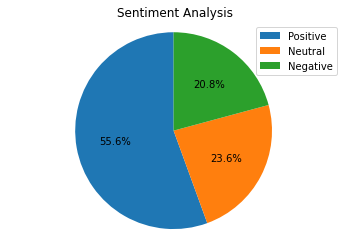

In [14]:
# create pie chart of polarity
pie_pd = pd.DataFrame(pie)

my_labels = 'Positive','Neutral','Negative'
plt.pie(pie_pd['Sentiment'], autopct='%1.1f%%', startangle = 90)
plt.title('Sentiment Analysis')
plt.axis('equal')
plt.legend(my_labels, loc="best")
plt.show()

# Length of the tweets (number of words)

In [15]:
# word tokenization
all_tweets['Tweet'] = all_tweets['Tweet'].apply(nltk.word_tokenize)

<ipython-input-15-28476a1c62f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].apply(nltk.word_tokenize)


In [16]:
# remove stopwords
stopwordlist = stopwords()
all_tweets['Tweet'] = all_tweets['Tweet'].apply(lambda x: list(set([text.lower() for text in x 
                                   if text.lower() not in stopwordlist and text.lower() not in string.punctuation])))

<ipython-input-16-81817ad21f44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet'] = all_tweets['Tweet'].apply(lambda x: list(set([text.lower() for text in x


In [17]:
# stemming
stemmer = PorterStemmer()
all_tweets['Tweet'].apply(lambda w: [stemmer.stem(t) for t in w]) 

0      [corrupt, modern, worst, donald, presid, histo...
1                    [vote, hand, chang, countri, power]
2      [grow, obama, donald, life, economi, presid, t...
3      [member, vote, african, commun, speak, futur, ...
4      [loud, messag, leav, vote, white, donald, hear...
                             ...                        
874    [nation, commun, challeng, convers, wisconsin,...
875    [instead, hum, new, excit, job, students_, sil...
876    [nation, best, turbul, threshold, futur, belie...
877    [putin, regim, poison, refus, navalni, exampl,...
878                      [hide, return, releas, tax, 21]
Name: Tweet, Length: 846, dtype: object

In [18]:
# create new column for number of words in tweets
all_tweets['Tweet_length'] = all_tweets['Tweet'].apply(lambda x: len(x))

<ipython-input-18-07f16ec6c0be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet_length'] = all_tweets['Tweet'].apply(lambda x: len(x))


In [19]:
# get all columns stats information
all_tweets.describe()

,ID,Reply_count,Retweet_count,Like_count,FRE,Neg_pol,Pos_pol,Neu_pol,Compound,Tweet_length
count,8.460000e+02,846.000000,846.000000,8.460000e+02,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,1.314772e+18,5607.776596,15034.667849,9.768625e+04,75.066939,0.060473,0.127874,0.811645,0.203247,10.572104
std,6.394409e+15,6613.414468,22888.841267,1.522697e+05,17.671761,0.096892,0.132186,0.147997,0.517150,5.657388
min,1.301316e+18,81.000000,619.000000,2.497000e+03,-6.700000,0.000000,0.000000,0.000000,-0.972900,0.000000
25%,1.309970e+18,1856.750000,4037.000000,2.067800e+04,65.262500,0.000000,0.000000,0.722000,0.000000,6.000000
50%,1.315777e+18,3302.500000,8114.500000,4.255750e+04,76.540000,0.000000,0.108000,0.818000,0.226300,10.000000
75%,1.320392e+18,6327.000000,17658.000000,1.136115e+05,86.710000,0.098000,0.200000,0.924000,0.659700,15.000000
max,1.323410e+18,52117.000000,303586.000000,1.838618e+06,121.220000,0.796000,1.000000,1.000000,0.979400,27.000000


Text(0.5, 1.0, 'Histogram of number of words in tweets')

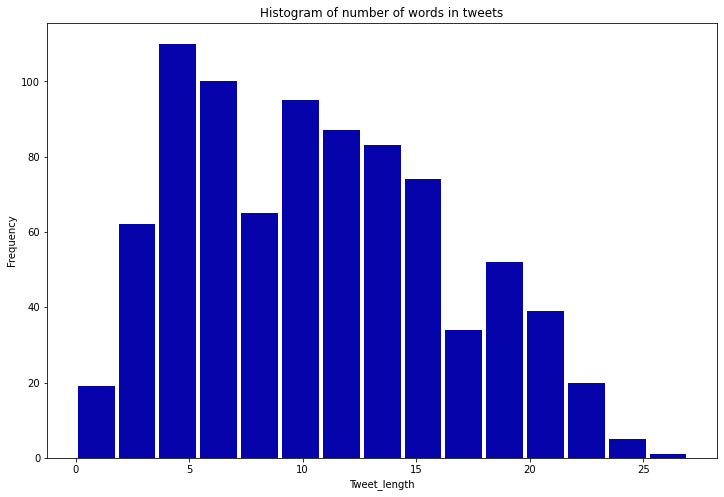

In [20]:
# histogram for number of words in tweets
number_words = all_tweets.hist(column='Tweet_length', bins='auto', color='#0504aa',
                            grid=False, figsize=(12,8), zorder=2, rwidth=0.9)
plt.xlabel('Tweet_length')
plt.ylabel('Frequency')
plt.title('Histogram of number of words in tweets') 

# Hourly tweets

In [21]:
# we can convert date column in datetime formate using to_datetime and split time but not able to groupby 
# split date column in time
time = [item.split(" ")[1] for item in all_tweets['Date'].values] 

# take only hours from time
hour = [item.split(":")[0] for item in time]
all_tweets['Tweet_time'] = hour

# groupby hour and count number of tweets 
all_tweets_time = all_tweets.groupby(['Tweet_time']).size().reset_index(name='Number_tweets')
all_tweets_time

<ipython-input-21-0b4153e6ae81>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Tweet_time'] = hour


,Tweet_time,Number_tweets
0,00,90
1,01,69
2,02,52
3,03,15
4,04,5
5,05,2
6,11,5
7,12,12
8,13,21
9,14,49


Text(0.5, 1.0, 'Histogram of tweet time')

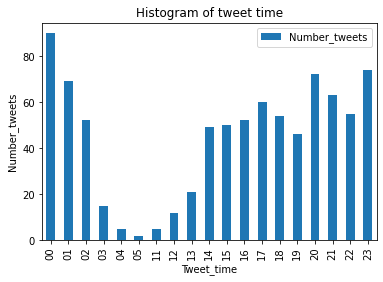

In [22]:
# create bar plot 
tweet_hours = all_tweets_time.reset_index().plot(x = 'Tweet_time', y = 'Number_tweets', kind ='bar')
plt.xlabel('Tweet_time')
plt.ylabel('Number_tweets')
plt.title('Histogram of tweet time')

# Lexicon sentiment analysis

In [23]:
# remove rows which has 0 words in tweets
all_tweets = all_tweets[all_tweets['Tweet_length'] != 0]
all_tweets.shape

(840, 14)

In [24]:
strong = open('strong.txt', 'r')
weak = open('weak.txt', 'r')
hostile = open('hostile.txt', 'r')
pleasure = open('pleasure.txt', 'r')

strongwordlist = [x.lower().strip('\n') for x in strong]
weakwordlist = [x.lower().strip('\n') for x in weak]
hostilewordlist = [x.lower().strip('\n') for x in hostile]
pleasurewordlist = [x.lower().strip('\n') for x in pleasure]
      
all_tweets['Strong'] = all_tweets['Tweet'].apply(lambda x: sum([1 if word in strongwordlist else 0 for word in x])/len(x))
all_tweets['Weak'] = all_tweets['Tweet'].apply(lambda x: sum([1 if word in weakwordlist else 0 for word in x])/len(x))
all_tweets['Hostile'] = all_tweets['Tweet'].apply(lambda x: sum([1 if word in hostilewordlist else 0 for word in x])/len(x))
all_tweets['Pleasure'] = all_tweets['Tweet'].apply(lambda x: sum([1 if word in pleasurewordlist else 0 for word in x])/len(x))

all_tweets

<ipython-input-24-cd6e66cf7cbc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Strong'] = all_tweets['Tweet'].apply(lambda x: sum([1 if word in strongwordlist else 0 for word in x])/len(x))
<ipython-input-24-cd6e66cf7cbc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tweets['Weak'] = all_tweets['Tweet'].apply(lambda x: sum([1 if word in weakwordlist else 0 for word in x])/len(x))
<ipython-input-24-cd6e66cf7cbc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,ID,Date,Tweet,Reply_count,Retweet_count,Like_count,FRE,Sentiment,Neg_pol,Pos_pol,Neu_pol,Compound,Tweet_length,Tweet_time,Strong,Weak,Hostile,Pleasure
0,1323409554567094272,2020-11-02 23:40:00+00:00,"[corrupt, modern, worst, donald, president, hi...",18961,31847,207292,61.83,Negative,0.189,0.000,0.811,-0.8553,8,23,0.125000,0.0,0.0,0.000000
1,1323404521523982338,2020-11-02 23:20:00+00:00,"[vote, hands, change, country, power]",1630,3452,19379,94.15,Neutral,0.000,0.000,1.000,0.0000,5,23,0.000000,0.0,0.0,0.000000
2,1323400746939883522,2020-11-02 23:05:00+00:00,"[growing, obama, donald, life, economy, presid...",11611,34213,260334,58.28,Positive,0.000,0.220,0.780,0.6705,9,23,0.111111,0.0,0.0,0.000000
3,1323391493885718528,2020-11-02 22:28:14+00:00,"[members, vote, african, community, speaking, ...",1538,1896,13395,60.99,Neutral,0.000,0.000,1.000,0.0000,10,22,0.100000,0.0,0.0,0.000000
4,1323383130435260419,2020-11-02 21:55:00+00:00,"[loud, message, leave, votes, white, donald, h...",5853,16643,141492,80.11,Positive,0.034,0.075,0.891,0.3400,11,21,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,1301594146390466562,2020-09-03 18:53:21+00:00,"[nation, community, challenges, conversation, ...",2166,4127,14866,67.25,Positive,0.000,0.051,0.949,0.0772,9,18,0.222222,0.0,0.0,0.000000
875,1301560082933530625,2020-09-03 16:38:00+00:00,"[instead, humming, new, excitement, job, stude...",7468,15454,77576,66.44,Positive,0.103,0.128,0.769,0.2960,18,16,0.055556,0.0,0.0,0.055556
876,1301535924111761408,2020-09-03 15:02:00+00:00,"[nation, best, turbulent, threshold, future, b...",4873,12480,74454,71.14,Positive,0.000,0.182,0.818,0.7964,10,15,0.000000,0.0,0.1,0.000000
877,1301322769045557250,2020-09-03 00:55:00+00:00,"[putin, regime, poisoning, refused, navalny, e...",3723,9402,35384,86.40,Negative,0.133,0.000,0.867,-0.7184,14,00,0.142857,0.0,0.0,0.000000


# Topic Modelling

###### Refered this article https://towardsdatascience.com/lda-topic-modeling-with-tweets-deff37c0e131
###### https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2

In [25]:
# step 1: 
# iterate through each tweet, then each token in each tweet
flat_words = [item for sublist in all_tweets['Tweet'] for item in sublist]
word_freq = nltk.FreqDist(flat_words).most_common(10)
common_words = [w[0] for w in word_freq]
# print(common_words)

# remove most common words
for tweetlist in all_tweets['Tweet']:
    for t in tweetlist:
        if t in common_words:
            tweetlist.remove(t)

# check most common words after removing
rm_common_words = [wrds for sblst in all_tweets['Tweet'] for wrds in sblst]
wordlist = nltk.FreqDist(rm_common_words)
# print(wordlist)

In [26]:
#retrieve word and count from FreqDist tuples
most_common_count = [x[1] for x in wordlist.most_common(100)]
most_common_word = [x[0] for x in wordlist.most_common(100)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

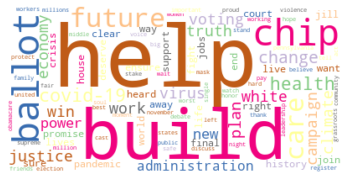

In [32]:
wc = WordCloud(colormap = 'Accent', background_color = 'white').generate_from_frequencies(top_30_dictionary)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [33]:
# Step 2: generating dictionary
token_id = corpora.Dictionary(all_tweets.Tweet) # this is all words. All the words appearing in all the documents
token_id.token2id

{'corrupt': 0,
 'history': 1,
 'jobs': 2,
 'modern': 3,
 'president': 4,
 'racist': 5,
 'worst': 6,
 'change': 7,
 'hands': 8,
 'power': 9,
 'economy': 10,
 'growing': 11,
 'inherited': 12,
 'life': 13,
 'obama': 14,
 'squandered': 15,
 'truth': 16,
 'african': 17,
 'build': 18,
 'community': 19,
 'future': 20,
 'members': 21,
 'pittsburgh': 22,
 'speaking': 23,
 'believe': 24,
 'clear': 25,
 'heard': 26,
 'house': 27,
 'leave': 28,
 'loud': 29,
 'message': 30,
 'votes': 31,
 'white': 32,
 'accelerate': 33,
 'access': 34,
 'administration': 35,
 'biden-harris': 36,
 'control': 37,
 'development': 38,
 'distribution': 39,
 'effective': 40,
 'ensure': 41,
 'free': 42,
 'getting': 43,
 'implement': 44,
 'mandates': 45,
 'mask': 46,
 'nationwide': 47,
 'regular': 48,
 'reliable': 49,
 'safe': 50,
 'testing': 51,
 'treatments': 52,
 'vaccines': 53,
 'virus': 54,
 'waste': 55,
 'care': 56,
 'civil': 57,
 'climate': 58,
 'court': 59,
 'democracy': 60,
 'economic': 61,
 'health': 62,
 'inequal

In [34]:
# count of how many times a word token occurs within a tweets
tweets_bow = [token_id.doc2bow(tweet) for tweet in all_tweets['Tweet']]
# print(tweets_bow)

In [35]:
# Generate LDA model
import gensim
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(tweets_bow, num_topics=13, id2word = token_id, passes = 250, chunksize = 20)
ldamodel.show_topics()

[(7,
  '0.045*"jobs" + 0.037*"voting" + 0.031*"right" + 0.027*"history" + 0.026*"months" + 0.026*"watch" + 0.026*"day" + 0.025*"deal" + 0.022*"track" + 0.022*"debate"'),
 (9,
  '0.052*"moment" + 0.034*"ahead" + 0.030*"proud" + 0.029*"chance" + 0.024*"running" + 0.023*"shot" + 0.022*"heal" + 0.020*"commit" + 0.019*"goal" + 0.015*"miss"'),
 (0,
  '0.033*"health" + 0.028*"justice" + 0.028*"care" + 0.026*"change" + 0.024*"climate" + 0.022*"act" + 0.021*"deserve" + 0.019*"court" + 0.017*"crisis" + 0.016*"millions"'),
 (6,
  '0.000*"second" + 0.000*"term" + 0.000*"turned" + 0.000*"suffer" + 0.000*"nationalblackvoterday" + 0.000*"train" + 0.000*"saddle" + 0.000*"trust" + 0.000*"taken" + 0.000*"prevent"'),
 (12,
  '0.000*"second" + 0.000*"term" + 0.000*"turned" + 0.000*"suffer" + 0.000*"nationalblackvoterday" + 0.000*"train" + 0.000*"saddle" + 0.000*"trust" + 0.000*"taken" + 0.000*"prevent"'),
 (11,
  '0.090*"future" + 0.033*"best" + 0.029*"community" + 0.028*"ginsburg" + 0.027*"join" + 0.026*

In [46]:
# printing words in all topics
first_topic = ldamodel.print_topics(num_topics = -1, num_words = 50)
first_topic

[(0,
  '0.033*"health" + 0.028*"justice" + 0.028*"care" + 0.026*"change" + 0.024*"climate" + 0.022*"act" + 0.021*"deserve" + 0.019*"court" + 0.017*"crisis" + 0.016*"millions" + 0.016*"supreme" + 0.013*"ago" + 0.012*"fact" + 0.012*"rights" + 0.012*"action" + 0.012*"florida" + 0.012*"protections" + 0.011*"tax" + 0.010*"law" + 0.010*"think" + 0.009*"example" + 0.009*"they_re" + 0.009*"respect" + 0.009*"stake" + 0.009*"democracy" + 0.009*"unions" + 0.008*"economic" + 0.008*"nation_s" + 0.008*"loved" + 0.008*"things" + 0.008*"trying" + 0.008*"thing" + 0.007*"threat" + 0.007*"unconscionable" + 0.007*"leaders" + 0.007*"hear" + 0.007*"senate" + 0.007*"human" + 0.007*"existential" + 0.007*"weeks" + 0.006*"congress" + 0.006*"latest" + 0.006*"bad" + 0.006*"stronger" + 0.006*"coast" + 0.006*"veterans" + 0.006*"hearts" + 0.005*"word" + 0.005*"depends" + 0.005*"decision"'),
 (1,
  '0.032*"build" + 0.022*"virus" + 0.020*"promise" + 0.019*"economy" + 0.019*"truth" + 0.018*"ensure" + 0.018*"administrat

In [37]:
# topic distribution
topic_distribuition_list=[]
for i in range(len(tweets_bow)):
    distribution=dict(ldamodel.get_document_topics(tweets_bow[i])) # note taht the distribution only show topics with loading, such as {0: 0.10538977, 7: 0.89361304}
    template_dict=dict.fromkeys(range(13),0) # we need to fill the missing toipcs in the distribution (missing because the loading is 0), this is to create a template of empty dictionary with all 0 values
    template_dict.update(distribution)
    topic_distribuition_list.append(template_dict)

print(topic_distribuition_list)

[{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0.8845687, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}, {0: 0.019231426, 1: 0.019231057, 2: 0.019231057, 3: 0.7692269, 4: 0.019231057, 5: 0.019231057, 6: 0.019231057, 7: 0.019231057, 8: 0.019231057, 9: 0.019231057, 10: 0.019231057, 11: 0.019231057, 12: 0.019231057}, {0: 0.010973964, 1: 0.8683124, 2: 0.010973964, 3: 0.010973965, 4: 0.010973964, 5: 0.010973967, 6: 0.010973967, 7: 0.010973965, 8: 0.010973965, 9: 0.010973965, 10: 0.010973964, 11: 0.010973965, 12: 0.010973967}, {0: 0, 1: 0.11970037, 2: 0, 3: 0.119699694, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0.6750957, 12: 0}, {0: 0, 1: 0, 2: 0, 3: 0.13450071, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0.13471533, 10: 0.6349759, 11: 0, 12: 0}, {0: 0, 1: 0.91988957, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0.04485201, 11: 0, 12: 0}, {0: 0.93852246, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}, {0: 0.019231115, 1: 0.7692267, 2: 0.019231115, 3: 0.019231115, 4: 0.019231

In [38]:
# convert topic distribution dictionary into dataframe
df_new = pd.DataFrame.from_dict(topic_distribuition_list, orient = 'columns')

# reset index of main dataframe
all_tweets.reset_index(drop=True, inplace=True)

# concatenate main and topic distribbution dataframes
all_tweets = pd.concat([all_tweets, df_new], axis = 1)

In [39]:
# create key list
range_lst = list(range(13))

# create value list
topic_lst = []
for i in range(13):
    topic_lst.append(f'Topic{i}')
# print(topic_lst)
# create dictionary of column names
column_dict = dict(zip(range_lst, topic_lst))
# print(column_dict)
# rename column names
all_tweets.rename(columns=column_dict, inplace=True)
all_tweets

,ID,Date,Tweet,Reply_count,Retweet_count,Like_count,FRE,Sentiment,Neg_pol,Pos_pol,...,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12
0,1323409554567094272,2020-11-02 23:40:00+00:00,"[corrupt, modern, worst, president, history, j...",18961,31847,207292,61.83,Negative,0.189,0.000,...,0.000000,0.000000,0.000000,0.000000,0.884569,0.000000,0.000000,0.000000,0.000000,0.000000
1,1323404521523982338,2020-11-02 23:20:00+00:00,"[hands, change, power]",1630,3452,19379,94.15,Neutral,0.000,0.000,...,0.769227,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231
2,1323400746939883522,2020-11-02 23:05:00+00:00,"[growing, obama, life, economy, truth, squande...",11611,34213,260334,58.28,Positive,0.000,0.220,...,0.010974,0.010974,0.010974,0.010974,0.010974,0.010974,0.010974,0.010974,0.010974,0.010974
3,1323391493885718528,2020-11-02 22:28:14+00:00,"[members, african, community, speaking, future...",1538,1896,13395,60.99,Neutral,0.000,0.000,...,0.119700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.675096,0.000000
4,1323383130435260419,2020-11-02 21:55:00+00:00,"[loud, message, leave, votes, white, heard, ho...",5853,16643,141492,80.11,Positive,0.034,0.075,...,0.134501,0.000000,0.000000,0.000000,0.000000,0.000000,0.134715,0.634976,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,1301594146390466562,2020-09-03 18:53:21+00:00,"[community, challenges, conversation, wisconsi...",2166,4127,14866,67.25,Positive,0.000,0.051,...,0.000000,0.119635,0.000000,0.000000,0.000000,0.000000,0.119658,0.000000,0.119660,0.000000
836,1301560082933530625,2020-09-03 16:38:00+00:00,"[instead, humming, new, excitement, job, stude...",7468,15454,77576,66.44,Positive,0.103,0.128,...,0.191099,0.096475,0.000000,0.000000,0.191962,0.000000,0.000000,0.187951,0.000000,0.000000
837,1301535924111761408,2020-09-03 15:02:00+00:00,"[best, turbulent, threshold, future, believed,...",4873,12480,74454,71.14,Positive,0.000,0.182,...,0.010745,0.010745,0.010745,0.010745,0.010745,0.010745,0.010745,0.010745,0.306690,0.010745
838,1301322769045557250,2020-09-03 00:55:00+00:00,"[putin, regime, poisoning, refused, navalny, e...",3723,9402,35384,86.40,Negative,0.133,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115440,0.000000,0.000000


In [40]:
# save dataframe in pickle
save_tweets=open('Biden_tweets','wb') #  must write byte
pickle.dump(all_tweets,save_tweets)
save_tweets.close()

In [41]:
tweets_open=open('Biden_tweets','rb')
all_tweets=pickle.load(tweets_open)

In [42]:
all_tweets.describe()

,ID,Reply_count,Retweet_count,Like_count,FRE,Neg_pol,Pos_pol,Neu_pol,Compound,Tweet_length,...,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12
count,8.400000e+02,840.000000,840.000000,8.400000e+02,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,1.314792e+18,5589.348810,14970.272619,9.721318e+04,74.829107,0.060905,0.127596,0.811490,0.204320,10.647619,...,0.089649,0.169722,0.008273,0.008273,0.067567,0.039730,0.045314,0.103758,0.056842,0.008273
std,6.412264e+15,6614.506334,22910.844781,1.524438e+05,17.466623,0.097103,0.128818,0.145132,0.518742,5.606239,...,0.163331,0.210229,0.012282,0.012282,0.132045,0.107717,0.121818,0.169456,0.116516,0.012282
min,1.301316e+18,81.000000,619.000000,2.497000e+03,-6.700000,0.000000,0.000000,0.000000,-0.972900,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.309939e+18,1854.250000,4004.250000,2.038975e+04,65.050000,0.000000,0.000000,0.721500,0.000000,6.000000,...,0.000000,0.010991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.315803e+18,3298.500000,7957.000000,4.212750e+04,76.220000,0.000000,0.109500,0.817500,0.226300,10.000000,...,0.015325,0.076923,0.000000,0.000000,0.015300,0.010958,0.010989,0.019209,0.012821,0.000000
75%,1.320406e+18,6253.500000,17514.000000,1.134765e+05,86.540000,0.098500,0.200250,0.923250,0.665675,15.000000,...,0.097893,0.269051,0.015283,0.015283,0.082795,0.019232,0.024968,0.131318,0.038463,0.015283
max,1.323410e+18,52117.000000,303586.000000,1.838618e+06,121.220000,0.796000,1.000000,1.000000,0.979400,27.000000,...,0.938432,0.916735,0.076923,0.076923,0.884569,0.815383,0.868119,0.868123,0.846062,0.076923


# Negative Binnomial Regression Model

###### I have used following link for NB model https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

###### NB model for Reply_count

In [43]:
# load dataset using pandas
df = all_tweets.iloc[:, 3:]
df = df.drop(['Tweet_time', 'Sentiment', 'Neg_pol', 'Pos_pol', 'Neu_pol'], axis = 1)
# df.columns

# create training and testing sets
sample = np.random.rand(len(df)) < 0.8
df_train = df[sample]
df_test = df[~sample]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

# step 1: Poission regression model on training set to find rate lambda
# here we used patsy 
expr = """Reply_count ~ FRE + Compound + Tweet_length + Strong + Weak +
Hostile + Pleasure + Topic0 + Topic1 + Topic2 + Topic3 +  Topic4 + Topic5 + Topic6 +
Topic7 + Topic8 + Topic9 + Topic10 + Topic11 + Topic12"""

# training and testing datset on training set
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

# train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

# rate vector
# print(poisson_training_results.mu)
# print(len(poisson_training_results.mu))

# step 2: auxiliary OLS regression model on the data set to get alpha
# add lambda in dataframe
df_train['Reply_LAMBDA'] = poisson_training_results.mu

# add alpha in dataframe
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Reply_count'] - x['Reply_LAMBDA'])**2 - x['Reply_LAMBDA']) / x['Reply_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ Reply_LAMBDA - 1"""

aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)

# print t-value
aux_olsr_results.tvalues

# Step 3: train NB2 model on traing data
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())

# Step 4: make predictions
nb2_predictions = nb2_training_results.get_prediction(X_test)

predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

Training data set length=683
Testing data set length=157
Reply_LAMBDA    1.018946
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:            Reply_count   No. Observations:                  683
Model:                            GLM   Df Residuals:                      664
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6516.6
Date:                Thu, 06 May 2021   Deviance:                       481.85
Time:                        01:12:19   Pearson chi2:                     658.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

<ipython-input-43-4b63a5c907c6>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Reply_LAMBDA'] = poisson_training_results.mu
<ipython-input-43-4b63a5c907c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Reply_count'] - x['Reply_LAMBDA'])**2 - x['Reply_LAMBDA']) / x['Reply_LAMBDA'], axis=1)


###### NB model for Like_count

In [44]:
# step 1: Poission regression model on training set to find rate lambda
# here we used patsy 
expr = """Like_count ~ FRE + Compound + Tweet_length + Strong + Weak +
Hostile + Pleasure + Topic0 + Topic1 + Topic2 + Topic3 +  Topic4 + Topic5 + Topic6 +
Topic7 + Topic8 + Topic9 + Topic10 + Topic11 + Topic12"""

# training and testing datset on training set
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

# train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

# rate vector
# print(poisson_training_results.mu)
# print(len(poisson_training_results.mu))

# step 2: auxiliary OLS regression model on the data set to get alpha
# add lambda in dataframe
df_train['Like_LAMBDA'] = poisson_training_results.mu

# add alpha in dataframe
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Like_count'] - x['Like_LAMBDA'])**2 - x['Like_LAMBDA']) / x['Like_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ Like_LAMBDA - 1"""

aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)

# print t-value
aux_olsr_results.tvalues

# Step 3: train NB2 model on traing data
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())

# Step 4: make predictions
nb2_predictions = nb2_training_results.get_prediction(X_test)

predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

Like_LAMBDA    1.43723
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Like_count   No. Observations:                  683
Model:                            GLM   Df Residuals:                      664
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8463.9
Date:                Thu, 06 May 2021   Deviance:                       479.13
Time:                        01:12:28   Pearson chi2:                     776.
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept 

<ipython-input-44-21f6930b2dc0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Like_LAMBDA'] = poisson_training_results.mu
<ipython-input-44-21f6930b2dc0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Like_count'] - x['Like_LAMBDA'])**2 - x['Like_LAMBDA']) / x['Like_LAMBDA'], axis=1)


###### NB model for Retweet count

In [45]:
# step 1: Poission regression model on training set to find rate lambda
# here we used patsy 
expr = """Retweet_count ~ FRE + Compound + Tweet_length + Strong + Weak +
Hostile + Pleasure + Topic0 + Topic1 + Topic2 + Topic3 +  Topic4 + Topic5 + Topic6 +
Topic7 + Topic8 + Topic9 + Topic10 + Topic11 + Topic12"""

# training and testing datset on training set
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

# train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

# rate vector
# print(poisson_training_results.mu)
# print(len(poisson_training_results.mu))

# step 2: auxiliary OLS regression model on the data set to get alpha
# add lambda in dataframe
df_train['Retweet_LAMBDA'] = poisson_training_results.mu

# add alpha in dataframe
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Retweet_count'] - x['Retweet_LAMBDA'])**2 - x['Retweet_LAMBDA']) / x['Retweet_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ Retweet_LAMBDA - 1"""

aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)

# print t-value
aux_olsr_results.tvalues

# Step 3: train NB2 model on traing data
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())

# Step 4: make predictions
nb2_predictions = nb2_training_results.get_prediction(X_test)

predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

Retweet_LAMBDA    1.681773
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:          Retweet_count   No. Observations:                  683
Model:                            GLM   Df Residuals:                      664
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7267.1
Date:                Thu, 06 May 2021   Deviance:                       343.57
Time:                        01:12:32   Pearson chi2:                     606.
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Interc

<ipython-input-45-11007ea4ef59>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Retweet_LAMBDA'] = poisson_training_results.mu
<ipython-input-45-11007ea4ef59>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Retweet_count'] - x['Retweet_LAMBDA'])**2 - x['Retweet_LAMBDA']) / x['Retweet_LAMBDA'], axis=1)
